<h3>Import packages

In [125]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb

<h3> Select options

In [126]:
case = 'bending' # bending / crushing
datatype = 'surrogate' # abaqus / surrogate

<h3>Read Abaqus data 

In [127]:
def read_data(case, folder, length):
    df = pd.DataFrame()
    parameters = pd.read_csv('Simulation_'+case+'/parameters_v1.txt')
    #parameters = pd.read_csv('random_extreme_values.csv')
    for i in range(length):
        if i+1 == 26:
            continue
        if i+1 == 100:
            continue
        new_data = pd.read_csv('Simulation_'+case+'/'+folder+'/'+case+'_X_data.csv/'+case+'_'+str(i+1)+'_data.csv')
        filtered_new_data = new_data[(new_data['DMM'] >= 7) & (new_data['DMM'] <= 25)]
        mean_force = filtered_new_data['FKN'].mean()
        max_force = new_data['FKN'].max()
        new_data_df = pd.DataFrame()
        new_data_df['mean_force'] = [mean_force]
        new_data_df['max_force'] = [max_force]
        for parameter in parameters.columns:
            new_data_df[parameter] = parameters[parameter][i]
        df = pd.concat([df, new_data_df])
    df = df.drop(columns=['sample'])
    df.reset_index(drop=True, inplace=True)
    return df

abaqus_df = read_data(case=case, folder='CONSTANT_THICKNESS_100', length=100)

<h3>Read data from surrogate modeling

In [128]:
df_max = pd.read_csv('Monte_Carlo_10000/monte_carlo_10000_predicted_'+case+'_max.csv')
df_mean = pd.read_csv('Monte_Carlo_10000/monte_carlo_10000_predicted_'+case+'_mean.csv')
surrogate_df = pd.merge(df_max, df_mean, 
                     on=['outer_wall_thickness', 'inside_wall_side_thickness', 'inside_wall_middle_thickness', 
                         'height', 'width', 'sigma0', 'youngs'])

<h3>Select correct data

In [129]:
if datatype == 'abaqus':
    df = abaqus_df
if datatype == 'surrogate':
    df = surrogate_df 


<h3>Correlation matrix

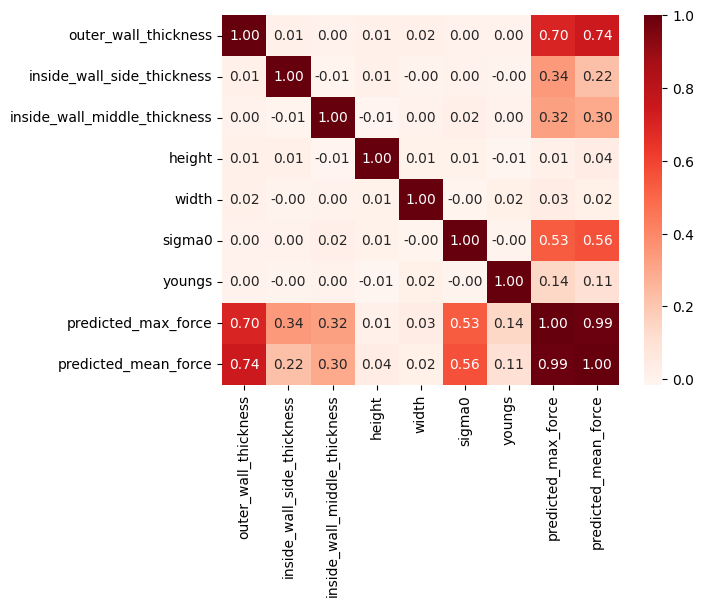

In [133]:
dataplot = sb.heatmap(df.corr(), fmt=".2f" ,cmap="Reds", annot=True)  
plt.show()

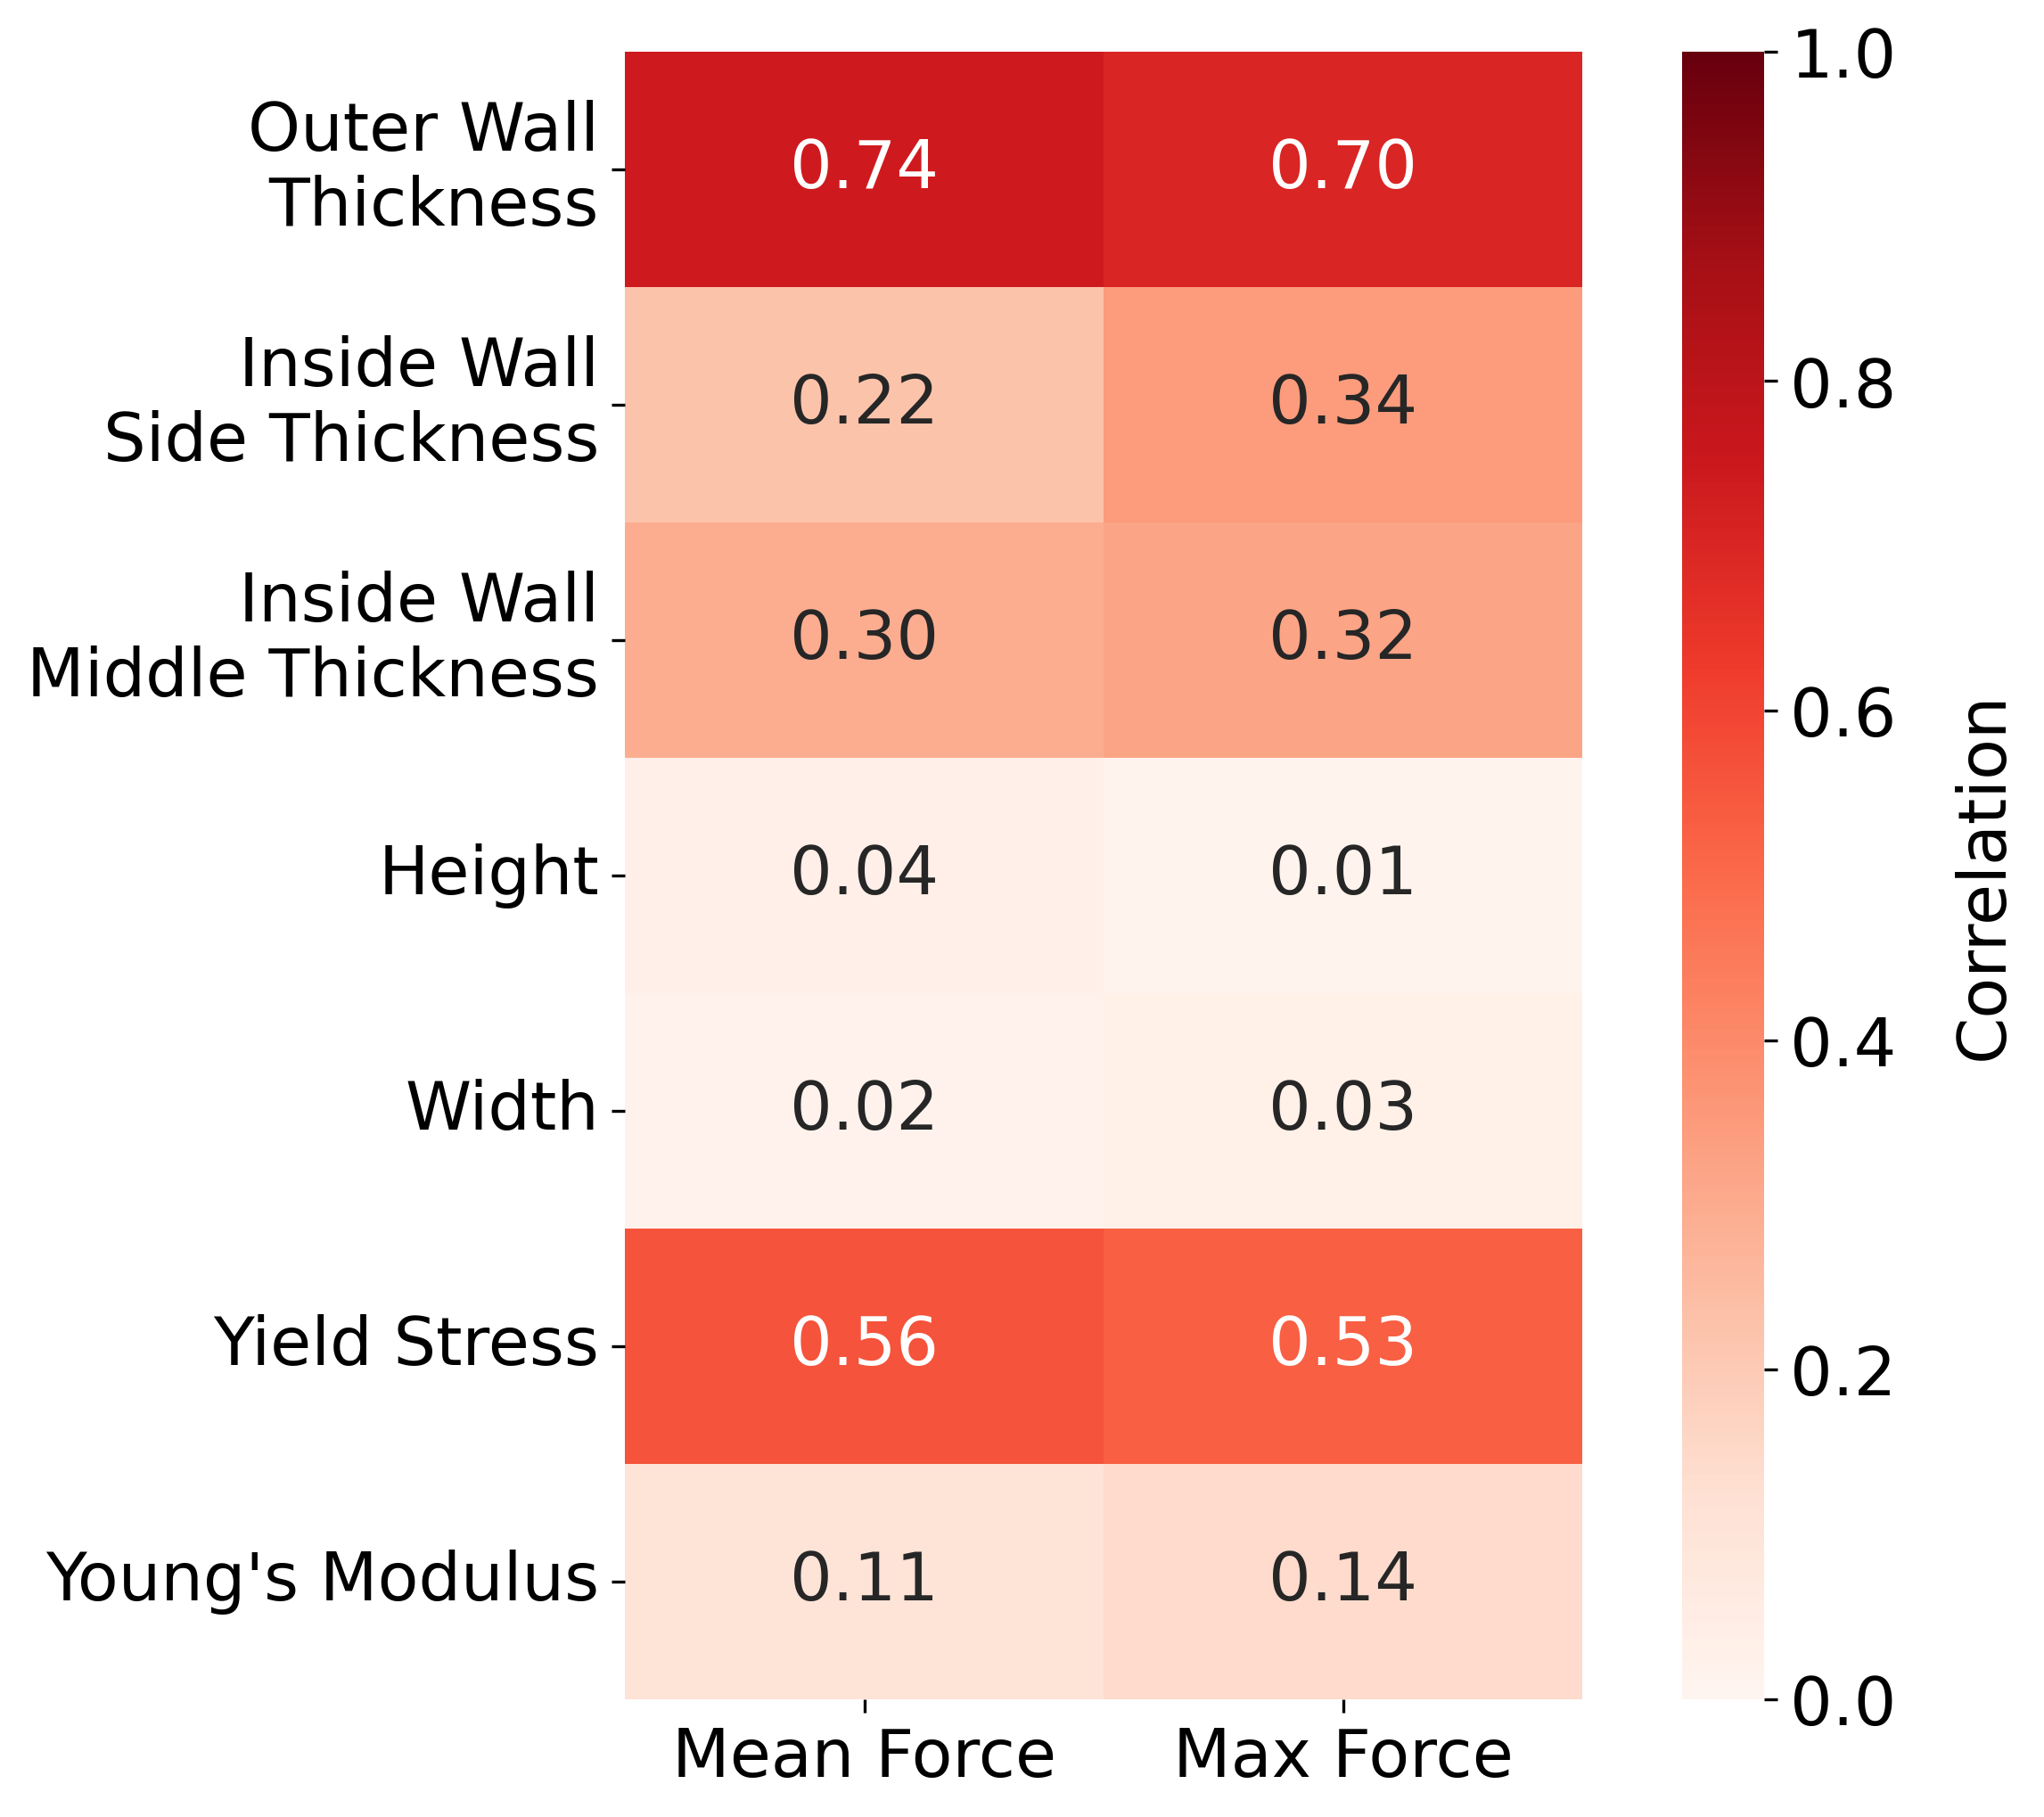

In [134]:
correlation_matrix = df.corr()

new_labels = {
    'outer_wall_thickness': 'Outer Wall\nThickness',
    'inside_wall_side_thickness': 'Inside Wall\nSide Thickness',
    'inside_wall_middle_thickness': 'Inside Wall\nMiddle Thickness',
    'height': 'Height',
    'width': 'Width',
    'mean_force': 'Mean Force',
    'max_force': 'Max Force',
    'predicted_mean_force': 'Mean Force',
    'predicted_max_force': 'Max Force',
    'sigma0': 'Yield Stress',
    'youngs': 'Young\'s Modulus'
}

correlation_matrix.rename(index=new_labels, columns=new_labels, inplace=True)

fkn_correlation = correlation_matrix[['Mean Force', 'Max Force']].drop('Mean Force').drop('Max Force')

plt.figure(figsize=(6, 8), dpi=300)

heatmap = sb.heatmap(fkn_correlation, annot=True, fmt=".2f", annot_kws={"fontsize": 18}, cmap='Reds', cbar=True, vmin=0, vmax=1, cbar_kws={'pad': 0.08})

colorbar = heatmap.collections[0].colorbar
colorbar.ax.tick_params(labelsize=18)
colorbar.set_label('Correlation', size=18, labelpad=15)

plt.xticks(fontsize=18) 
plt.yticks(fontsize=18)

plt.show()